In [1]:
%pylab inline

import astroclip
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.torch.loggers import WandbLogger

import lightning as L
from datasets import load_dataset
from astroclip.modules import AstroCLIP

wandb_logger = WandbLogger(log_model="all", project='astroclip')

In [5]:
dataset = load_dataset('../astroclip/datasets/legacy_survey.py',
                       keep_in_memory=True)
dataset.set_format(type='torch', columns=['image', 'spectrum'])

Using the latest cached version of the module from /mnt/home/flanusse/.cache/huggingface/modules/datasets_modules/datasets/legacy_survey/c0726de4348cccae31a8e45baab19a6ff563484b01f4c6e8a99cd766a145f946 (last modified on Sat Sep 30 20:09:10 2023) since it couldn't be found locally at legacy_survey., or remotely on the Hugging Face Hub.


In [7]:
import torchvision.models as models
from astroclip.networks.spectra import SpectrumEncoder

from torchvision.transforms import Compose, RandomVerticalFlip, RandomHorizontalFlip, RandomRotation, RandomErasing, ToTensor, CenterCrop, InterpolationMode
from astroclip.augmentations import ToRGB, AddGaussianNoise

image_transforms = Compose([
        ToRGB(),
        AddGaussianNoise(0,0.15),
        RandomRotation(45,interpolation=InterpolationMode.BILINEAR),
        RandomHorizontalFlip(),
        RandomVerticalFlip(),
        CenterCrop(96),
])

/tmp/ipykernel_3603778/2952377460.py:1: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3571.)
  imshow(image_transforms(dataset['train'][14]['image'].reshape([1,152,152,3]).to('cuda')).squeeze().cpu().T)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


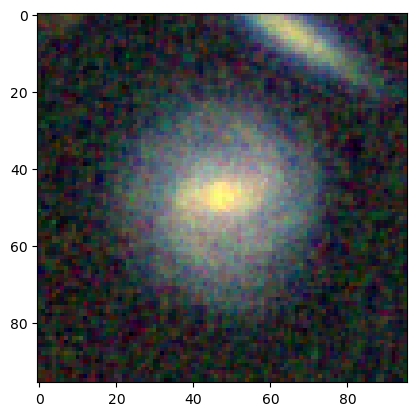

In [8]:
imshow(image_transforms(dataset['train'][14]['image'].reshape([1,152,152,3]).to('cuda')).squeeze().cpu().T)

In [ ]:
train_loader = DataLoader(dataset['train'], batch_size=2048, 
                          shuffle=True, num_workers=10, pin_memory=True, 
                          drop_last=True)

val_loader = DataLoader(dataset['test'], batch_size=1024, 
                        shuffle=False, num_workers=10, pin_memory=True, 
                        drop_last=True)

In [8]:
# Build the two model we will be using
spectrum_encoder = SpectrumEncoder(n_latent=256, instrument=None)
image_encoder = models.resnet18(num_classes=256, weights=None)

model = AstroCLIP(image_encoder, 
                  spectrum_encoder,
                  image_transform=image_transforms)

In [9]:
trainer = L.Trainer(callbacks=[
            ModelCheckpoint(
                every_n_epochs=5,
            )],
            logger=wandb_logger
            )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [ ]:
# Train model
trainer.fit(model, 
            train_dataloaders=train_loader, 
            val_dataloaders=val_loader)

/mnt/home/flanusse/.local/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:617: UserWarning: Checkpoint directory ./astroclip/3imrw90t/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name                | Type            | Params
--------------------------------------------------------
0 | image_encoder       | ResNet          | 11.3 M
1 | image_projection    | Linear          | 131 K 
2 | spectrum_encoder    | SpectrumEncoder | 3.2 M 
3 | spectrum_projection | Linear          | 131 K 
4 | criterion           | CLIPLoss        | 0     
--------------------------------------------------------
14.7 M    Trainable params
0         Non-trainable params
14.7 M    Total params
58.953    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

# testing

In [11]:
model = AstroCLIP.load_from_checkpoint('astroclip/3imrw90t/checkpoints/epoch=174-step=13546.ckpt',
                                      image_encoder=image_encoder, 
                                      spectrum_encoder=spectrum_encoder
                                      )

In [12]:
import numpy as np
def sdss_rgb(imgs, bands, scales=None,
             m = 0.02):
    import numpy as np
    rgbscales = {'u': (2,1.5), #1.0,
                 'g': (2,2.5),
                 'r': (1,1.5),
                 'i': (0,1.0),
                 'z': (0,0.4), #0.3
                 }
    if scales is not None:
        rgbscales.update(scales)

    I = 0
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        img = np.maximum(0, img * scale + m)
        I = I + img
    I /= len(bands)
        
    # b,g,r = [rimg * rgbscales[b] for rimg,b in zip(imgs, bands)]
    # r = np.maximum(0, r + m)
    # g = np.maximum(0, g + m)
    # b = np.maximum(0, b + m)
    # I = (r+g+b)/3.
    Q = 20
    fI = np.arcsinh(Q * I) / np.sqrt(Q)
    I += (I == 0.) * 1e-6
    H,W = I.shape
    rgb = np.zeros((H,W,3), np.float32)
    for img,band in zip(imgs, bands):
        plane,scale = rgbscales[band]
        rgb[:,:,plane] = (img * scale + m) * fI / I

    # R = fI * r / I
    # G = fI * g / I
    # B = fI * b / I
    # # maxrgb = reduce(np.maximum, [R,G,B])
    # # J = (maxrgb > 1.)
    # # R[J] = R[J]/maxrgb[J]
    # # G[J] = G[J]/maxrgb[J]
    # # B[J] = B[J]/maxrgb[J]
    # rgb = np.dstack((R,G,B))
    rgb = np.clip(rgb, 0, 1)
    return rgb

def dr2_rgb(rimgs, bands, **ignored):
    return sdss_rgb(rimgs, bands, scales=dict(g=(2,6.0), r=(1,3.4), z=(0,2.2)), m=0.03)

In [32]:
# Exporting results
dataset = load_dataset('legacy_survey')
import torch
dataset.set_format(type='torch', columns=['image', 'spectrum', 'redshift', 'targetid'])
testdata = torch.utils.data.DataLoader(dataset['train'], batch_size=512, shuffle=False, num_workers=10)

Using the latest cached version of the module from /mnt/home/flanusse/.cache/huggingface/modules/datasets_modules/datasets/legacy_survey/c0726de4348cccae31a8e45baab19a6ff563484b01f4c6e8a99cd766a145f946 (last modified on Sat Sep 30 20:09:10 2023) since it couldn't be found locally at legacy_survey., or remotely on the Hugging Face Hub.


In [ ]:
from tqdm import tqdm
embeddings = []
images = []
redshifts = []
spectra = []
source_spec = []
tids = []
for batch_test in tqdm(testdata):
    images.append(np.stack([clip(dr2_rgb(i.cpu().T, bands=['g', 'r', 'z']),0,1) for i in batch_test['image']] ,axis=0))
    spectra.append(model(spectrum=batch_test['spectrum'].squeeze().to('cuda')).detach().cpu().numpy())
    embeddings.append(model(image=image_transforms(batch_test['image'].transpose(1,3).to('cuda'))).detach().cpu().numpy())
    redshifts.append(batch_test['redshift'])
    source_spec.append(batch_test['spectrum'])
    tids.append(batch_test['targetid'])

In [34]:
images = np.concatenate(images, axis=0)
spectra = np.concatenate(spectra, axis=0)
embeddings = np.concatenate(embeddings, axis=0)
redshifts = np.concatenate(redshifts, axis=0)
source_spec = np.concatenate(source_spec, axis=0)
targetids = np.concatenate(tids, axis=0)

In [28]:
np.savez('data/prototype_embeddings.npz', 
         redshift=redshifts,
         image_features=embeddings,
         spectrum_features=spectra,
         images=images,
         spectra=source_spec,
         targetid=targetids)

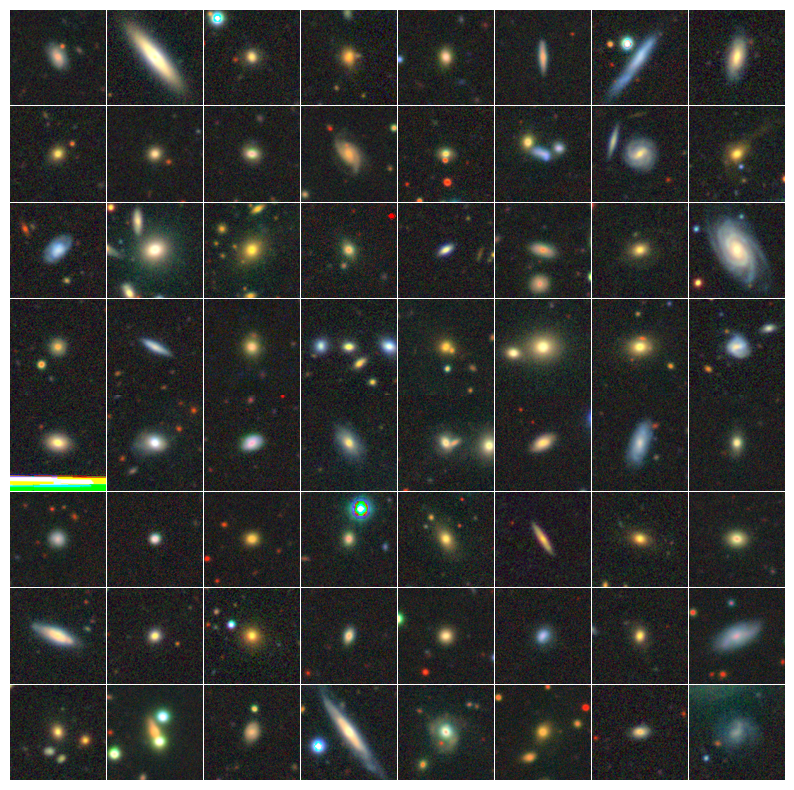

In [35]:
figure(figsize=[10,10])
for i in range(8):
    for j in range(8):
        subplot(8, 8, i * 8 +j +1)
        imshow(images[i * 8 +j])
        axis('off')
plt.subplots_adjust(wspace=0.01, hspace=0.01)

In [18]:
from scipy.ndimage import gaussian_filter1d

source_spec.shape
l = np.linspace(3586.7408577, 10372.89543574, len(source_spec[0]))

(0.0, 20.0)

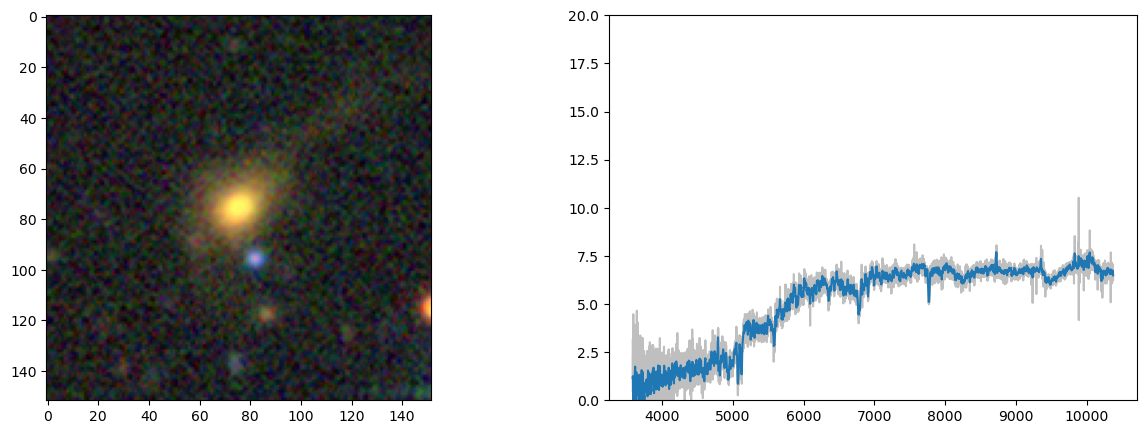

In [38]:
ind_query = 15
figure(figsize=[15,5])
subplot(121)
imshow(images[ind_query])
subplot(122)
plot(l,source_spec[ind_query], color='grey', alpha=0.5)
plot(l,gaussian_filter1d(source_spec[ind_query][:,0],2))
ylim(-0,20)

In [45]:
image_features = embeddings / np.linalg.norm(embeddings, axis=-1, keepdims=True)
spectra_features = spectra / np.linalg.norm(spectra, axis=-1, keepdims=True)
similarity = image_features[ind_query] @ image_features.T

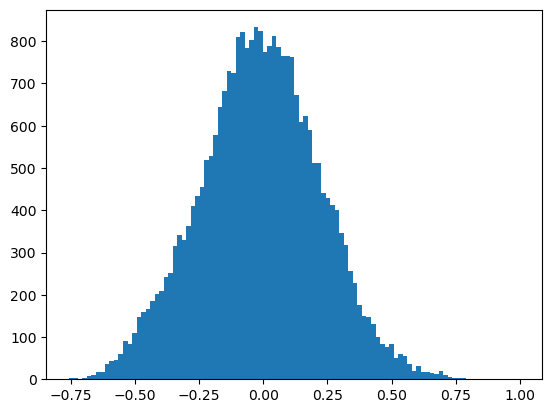

In [46]:
hist(similarity,100);

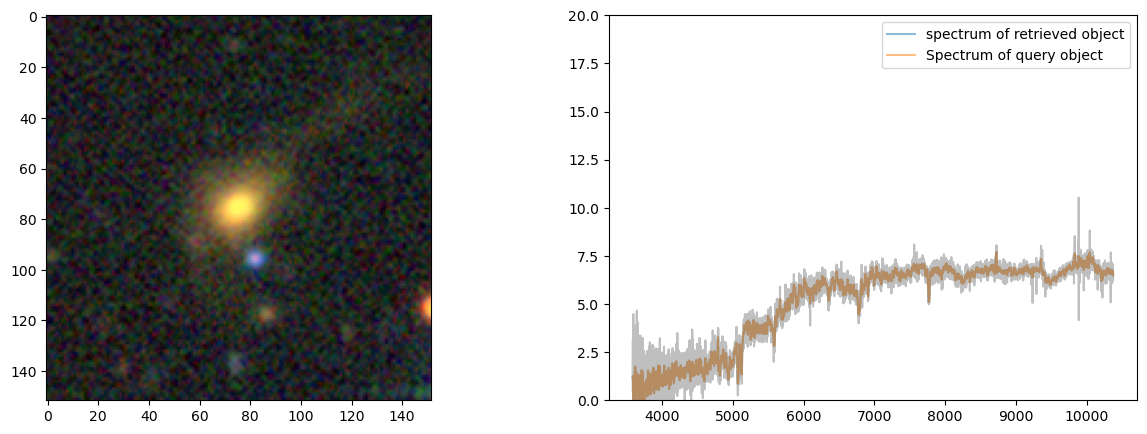

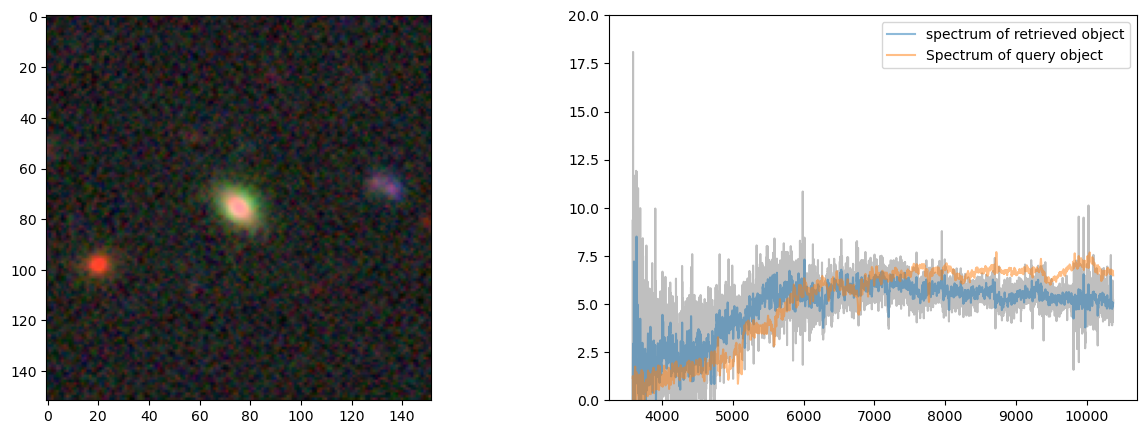

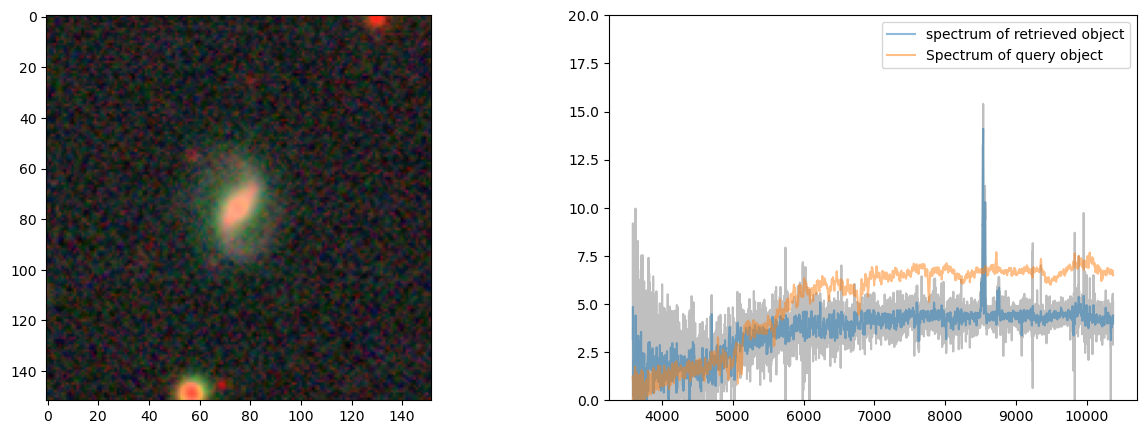

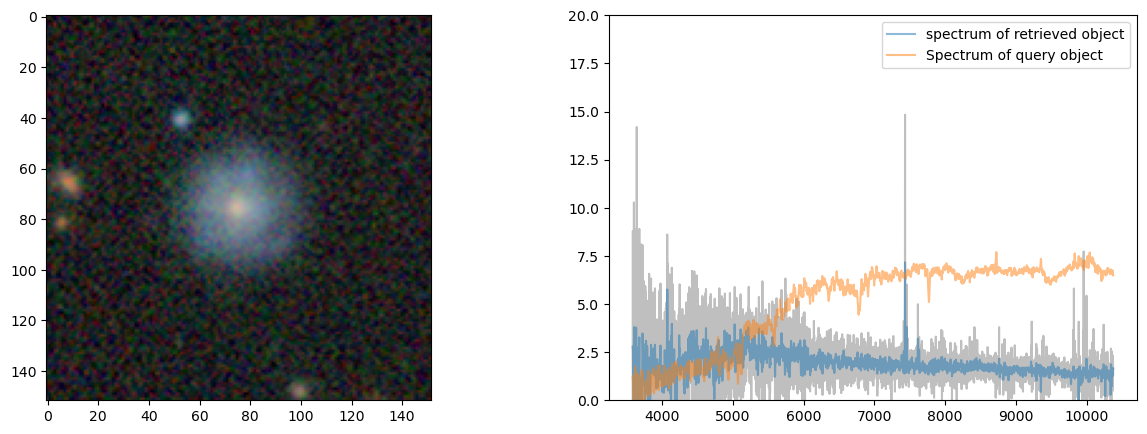

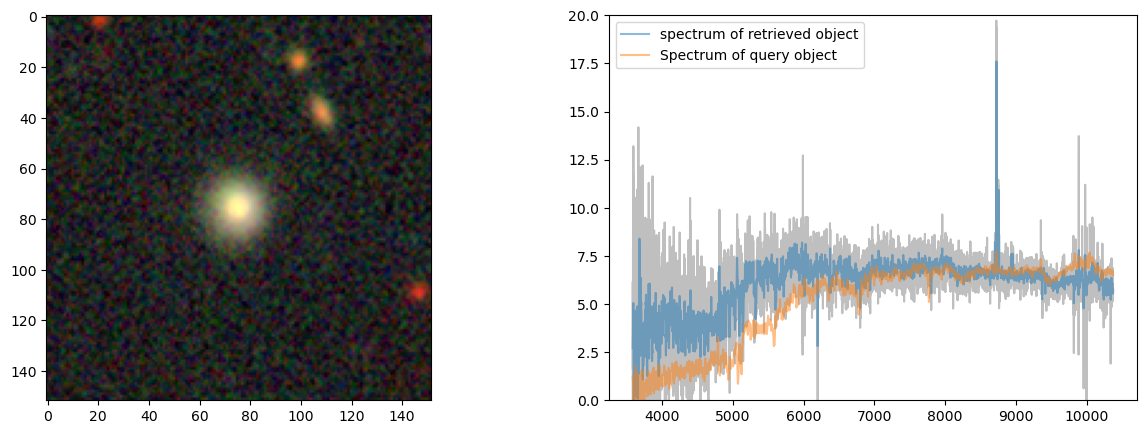

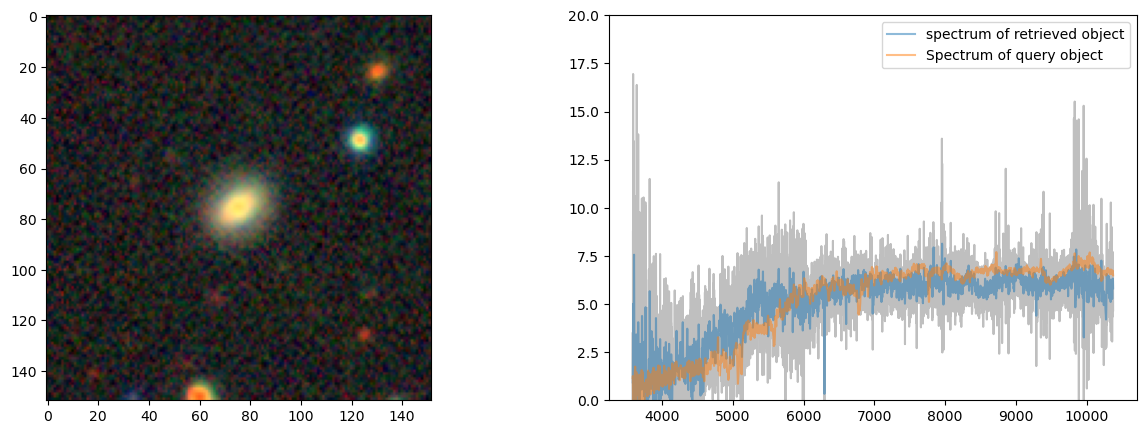

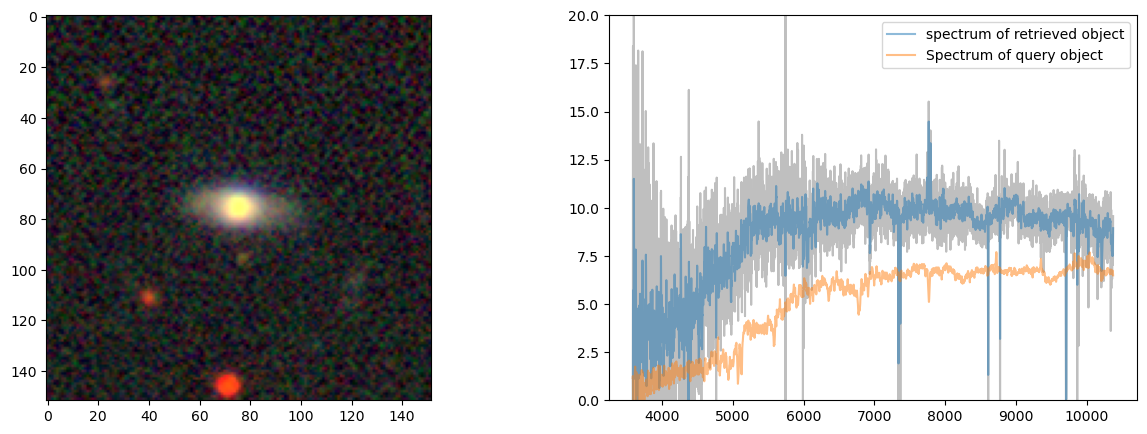

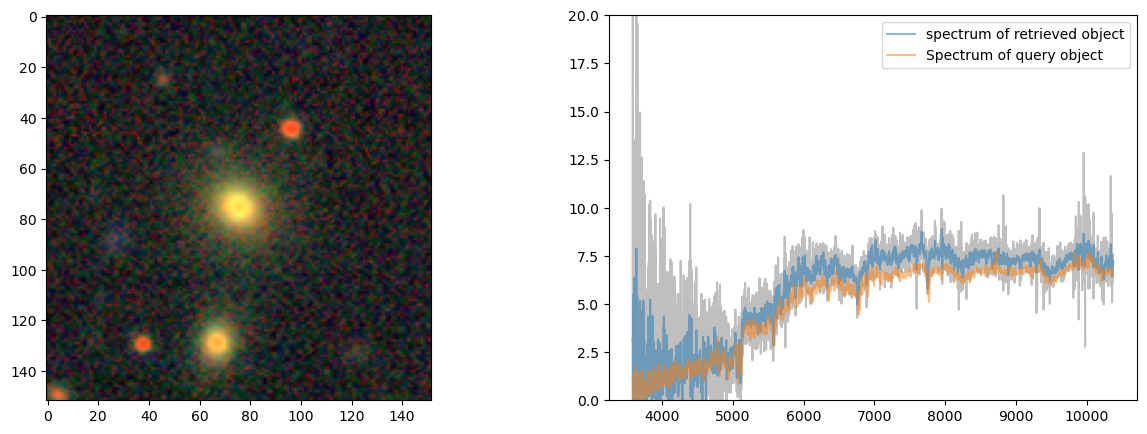

In [47]:
# And we can take a look at spectra of galaxies that match
# Spectral self-similarity
s = similarity
inds = argsort(s)[::-1]
for i in range(8):
    figure(figsize=[15,5])
    subplot(121)
    imshow(images[inds[i]])
    subplot(122)
    plot(l,source_spec[inds[i]], color='grey', alpha=0.5)
    plot(l,gaussian_filter1d(source_spec[inds[i]][:,0],2),alpha=0.5, label='spectrum of retrieved object')
    plot(l,gaussian_filter1d(source_spec[ind_query][:,0],2),alpha=0.5, label='Spectrum of query object')
    ylim(-0,20)
    legend()